In [31]:
#Imports

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [32]:
#Read the dataset

from google.colab import files 
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['TATAPOWER.NS.csv']))
df.head()

Saving TATAPOWER.NS.csv to TATAPOWER.NS (3).csv


,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,11.580205,11.662232,11.488529,11.628456,5.920809,33160.0
1,1996-01-02,11.628456,11.739433,11.396852,11.483704,5.847106,176162.0
2,1996-01-03,11.483704,11.599506,11.392027,11.411327,5.810253,104661.0
3,1996-01-04,11.411327,11.387202,11.155598,11.242449,5.724268,77718.0
4,1996-01-05,11.242449,11.483704,11.097697,11.464403,5.837279,113469.0


Text(0, 0.5, 'Close Price')

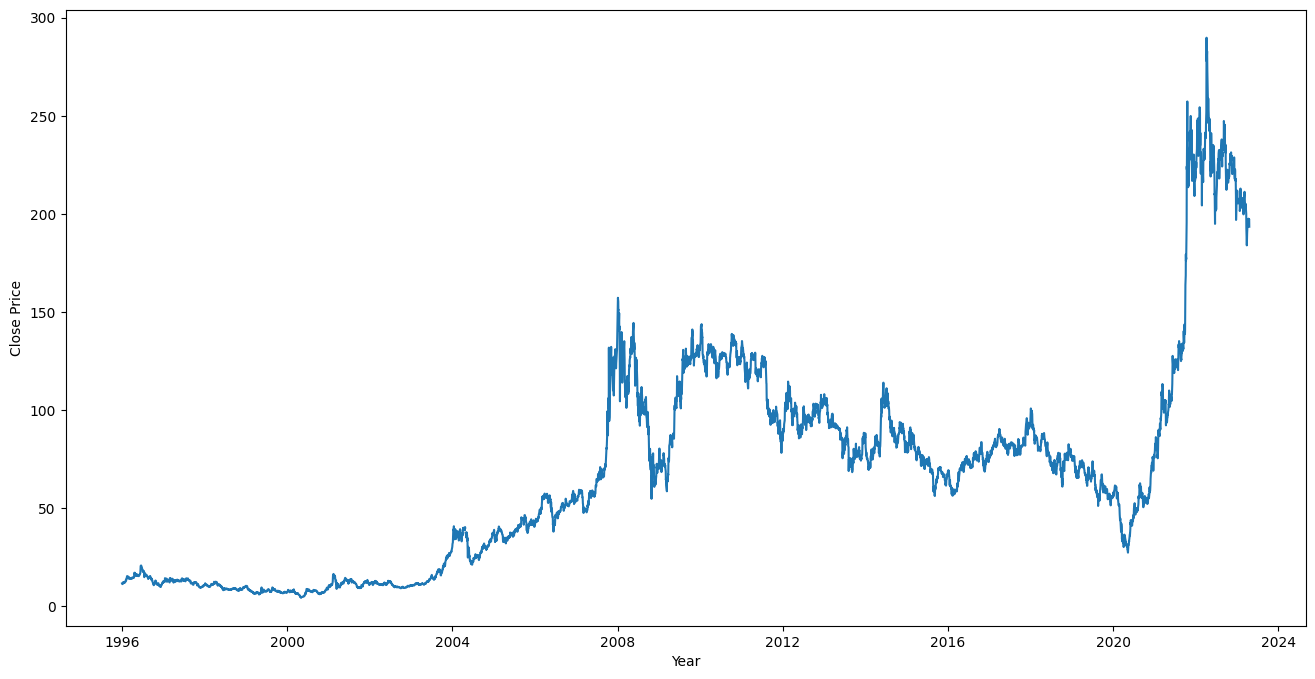

In [33]:
# Visualize the closing prices

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))

plt.plot(df["Close"],label='Close Price history')
plt.xlabel("Year")
plt.ylabel("Close Price") 

In [34]:
# Preprocessing the data

df = df.dropna()          # droping/removing NaN data points from the source

data=df.sort_index(ascending=True,axis=0)  # Sorting in asending order of the date

a= len(df)
reduced_df=pd.DataFrame(index=range(0,a),columns=['Date','Close'])  # Creating new dataset with only Date & Close price columns

for i in range(0,len(data)):
    reduced_df["Date"][i]=data['Date'][i]
    reduced_df["Close"][i]=data["Close"][i]

reduced_df.head()

,Date,Close
0,1996-01-01 00:00:00,11.628456
1,1996-01-02 00:00:00,11.483704
2,1996-01-03 00:00:00,11.411327
3,1996-01-04 00:00:00,11.242449
4,1996-01-05 00:00:00,11.464403


In [35]:
reduced_df.index=reduced_df.Date             # Making date column as the index
reduced_df.drop("Date",axis=1,inplace=True)  # Droping time stamp 00:00:00 from Date column
#print(reduced_df)

final_dataset=reduced_df.values    # Creating an array of close values using Date column as index

print("Dataset shape with only Values considered excluding date:",final_dataset.shape)
print("Dataset with only Values considered excluding date:\n",final_dataset)

Dataset shape with only Values considered excluding date: (6862, 1)
Dataset with only Values considered excluding date:
 [[11.628456]
 [11.483704]
 [11.411327]
 ...
 [196.949997]
 [197.25]
 [193.449997]]


In [23]:
# Splitting the data into Train & test by 80-20
train_data, test_data = train_test_split(final_dataset, test_size=0.2,shuffle=False)

print("Size of Train Data:",train_data.shape)
print("Train Data:\n", train_data)
print("Size of Test Data:",test_data.shape)
print("Test Data:\n", test_data)

Size of Train Data: (5489, 1)
Train Data: [[11.628456]
 [11.483704]
 [11.411327]
 ...
 [80.400002]
 [81.849998]
 [79.949997]]
Size of Test Data: (1373, 1)
Test Data: [[78.150002]
 [77.25]
 [77.800003]
 ...
 [196.949997]
 [197.25]
 [193.449997]]


In [24]:
#Normalize the new filtered dataset

scale=MinMaxScaler(feature_range=(0,1))
scaled_data=scale.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(100,len(train_data)):                   # Creating x_train data of 2D array 100 columns each
    x_train_data.append(scaled_data[i-100:i,0])
    y_train_data.append(scaled_data[i,0])             # Creating y_train data of 1D array with 100 columns

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))  # converting train data into 3D array since LSTM needs 3D Tensor

print("Training Data set Shape:",x_train_data.shape)

#print(x_train_data)
#data.head()

Training Data set Shape: (5389, 100, 1)


In [25]:
#Build and train the LSTM model

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

data_ip=reduced_df[len(reduced_df)-len(test_data)-100:].values
data_ip=data_ip.reshape(-1,1)
data_ip=scale.transform(data_ip)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

5389/5389 - 260s - loss: 2.8261e-04 - 260s/epoch - 48ms/step


In [26]:
#Make a prediction using the LSTM model

X_test=[]

for i in range(100,data_ip.shape[0]):
    X_test.append(data_ip[i-100:i,0])
    
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print("Testing Data set Shape:",X_test.shape)

predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scale.inverse_transform(predicted_closing_price)

print("Predicted Closing Price Sahep:",predicted_closing_price.shape)

Testing Data set Shape: (1373, 100, 1)
43/43 [==============================] - 3s 35ms/step
Predicted Closing Price Sahep: (1373, 1)


In [27]:
#lstm_model.save("saved_model.h5")

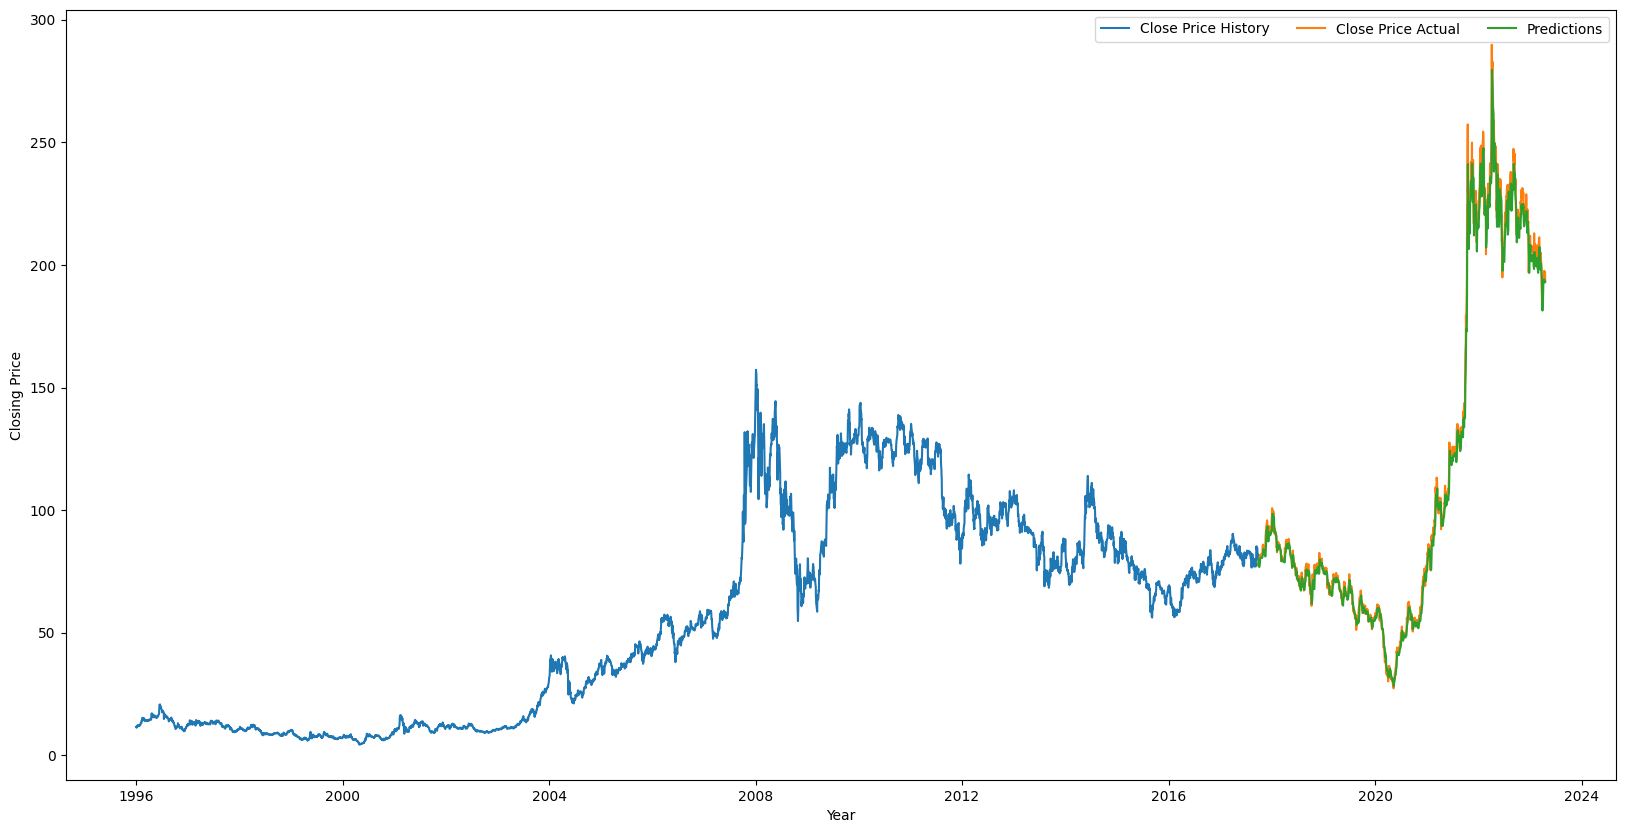

In [28]:
#Visualize the results

train_data=reduced_df[:train_data.shape[0]]
test_data=reduced_df[train_data.shape[0]:]
test_data['Predictions']=predicted_closing_price

plt.plot(train_data["Close"], label = "Close Price History")
plt.plot(test_data["Close"], label = "Close Price Actual")
plt.plot(test_data["Predictions"], label = "Predictions")
plt.legend(ncol=3, loc="upper right")
plt.xlabel("Year")
plt.ylabel("Closing Price")
pd.options.mode.chained_assignment = None



In [29]:
#test_data

test_data['Score_diff'] = test_data['Predictions'] - test_data['Close']

test_data

var = round(test_data['Score_diff'].var(),3)
mean = round(test_data['Score_diff'].mean(),3)

print("Avg differences between actual & predicted :", mean)

print("Variance between actual & predicted :", var)

pd.options.mode.chained_assignment = None 


Avg differences between actual & predicted : -2.156
Variance between actual & predicted : 17.009
